In [1]:
#!/usr/bin/env python
import os
import re
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
def load_file(f):
    df = pd.read_csv(f,
        delimiter=' ',
        header=None,
        names=['method', 'n', 'time', 'flips'],
        dtype={'method': str, 'n': int, 'time': float, 'flips': int}
        )
    df.method = df.method.str.replace('generate_', '')
    df = df[~df.method.str.contains('gsl_ran')]
    df['distribution'] = f
    df['bits/variate'] = df.flips / df.n
    df['variates/sec'] = df.n / df.time
    return df

df = pd.concat([load_file(f) for f in os.listdir() if '@' in f])
df = df[['distribution', 'method', 'bits/variate', 'variates/sec']]
df = df.pivot(index='distribution', columns='method', values=['bits/variate','variates/sec'])

In [3]:
for method in ['cbs', 'opt']:
    df[(method, f'ratio_flips')] = df[('bits/variate',f'{method}_ext')] / df[('bits/variate', method)]
    df[(method, f'ratio_runtime')] = df[('variates/sec', f'{method}_ext')] / df[('variates/sec', method)]

In [4]:
method = 'cbs'
df_cbs = pd.DataFrame(index=df.index)
df_cbs.loc[df.index, 'method'] = 'cbs'
df_cbs.loc[df.index, 'ratio_runtime'] = df[('variates/sec',f'{method}_ext')] / df[('variates/sec', method)]
df_cbs.loc[df.index, 'ratio_flips'] = df[('bits/variate',f'{method}_ext')] / df[('bits/variate', method)]

method = 'opt'
df_opt = pd.DataFrame(index=df.index)
df_opt.loc[df.index, 'method'] = 'opt'
df_opt.loc[df.index, 'ratio_runtime'] = df[('variates/sec',f'{method}_ext')] / df[('variates/sec', method)]
df_opt.loc[df.index, 'ratio_flips'] = df[('bits/variate',f'{method}_ext')] / df[('bits/variate', method)]

In [5]:
df = pd.concat((df_cbs, df_opt)).reset_index().sort_values(by=['distribution'])
df.index = np.arange(len(df))

In [6]:
plt.rcParams['figure.dpi'] = 200

legend = [
  'Beta(5,5)',
  'Binomial(.2,100)',
  'Cauchy(7)',
  'ChiSquare(13)',
  'Exponential(15)',
  'ExpPow(1,.5)',
  'Fdist(5,2)',
  'Flat(-7,3)',
  'Gamma(.5,1)',
  'Gaussian(15)',
  'Geometric(.4)',
  'Gumbel1(1,1)',
  'Gumbel2(1,5)',
  'Hypergeom(5,20,7)',
  'Laplace(2)',
  'Logistic(.5)',
  'Lognormal(1,1)',
  'NegBinomial(.71,18)',
  'Pareto(3,2)',
  'Pascal(1,5)',
  'Poisson(71)',
  'Rayleigh(11)',
  'Tdist(5)',
  'Weibull(2,3)',
  ]

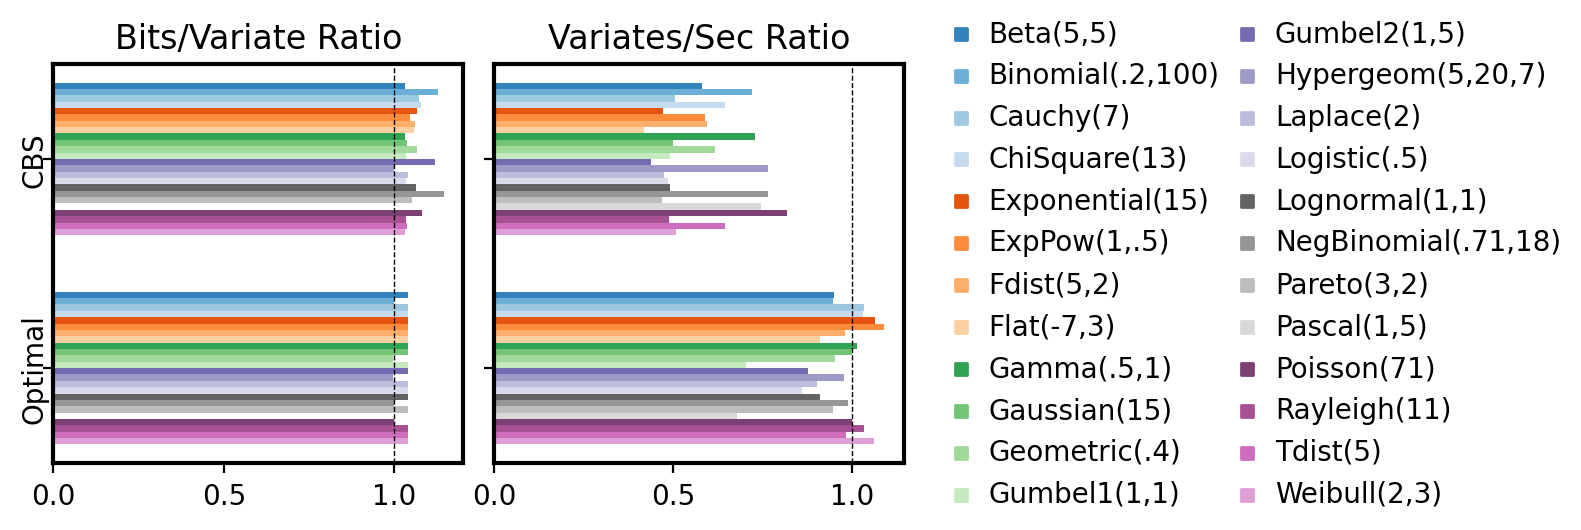

In [7]:
fig = plt.figure(figsize=(8, 2.75), tight_layout=True)
gs = plt.matplotlib.gridspec.GridSpec(1, 2, width_ratios=[4, 1])
gs0 = plt.matplotlib.gridspec.GridSpecFromSubplotSpec(1, 2, wspace=0.075, subplot_spec=gs[0])

axes = [
    fig.add_subplot(gs0[0]),
    fig.add_subplot(gs0[1]),
    fig.add_subplot(gs[1]),
    ]

methods = {
    'opt': 'Optimal',
    'cbs': 'CBS',
}

dists = pd.unique(df.distribution)
offsets = np.linspace(-.35, .35, num=len(dists))
cm1 = plt.colormaps['tab20c']
cm2 = plt.colormaps['tab20b']
colors = cm1.colors + cm2.colors[len(cm1.colors)-len(dists)::]
stores = {}

for ax, metric in zip(axes, ['ratio_flips', 'ratio_runtime']):
    for i, method in enumerate(methods):
        ratios = df[df.method == method][metric]
        stores[(metric,method)] = ratios
        # ax.scatter(ratios[:20],  + offsets, color=cm.colors, marker='o')
        ax.barh(
            y=[i]*len(ratios) - offsets,
            width=ratios,
            height=offsets[1]-offsets[0],
            color=colors,
            )
    ax.axvline(1, color='k', linestyle='--', linewidth=.5)

axes[0].set_yticks(range(len(methods)), labels=[methods[k] for k in methods], rotation=90, ha='center', va='center')
axes[1].set_yticks(range(len(methods)), labels=[])
axes[0].set_title('Bits/Variate Ratio')
axes[1].set_title('Variates/Sec Ratio')

# Make the legend.
for l, color in zip(legend, colors):
    axes[2].scatter([], [], color=color, marker='s', s=20, label=l)
axes[2].legend(loc='center', borderpad=0, ncol=2, handletextpad=0, framealpha=0, columnspacing=0)
axes[2].set_axis_off()

for ax in axes[:2]:
    for a in ['top','bottom','left','right']:
        ax.spines[a].set_linewidth(1.5)

In [8]:
fig.savefig('figure_8.png')